<a href="https://colab.research.google.com/github/prj-07/breed.detector.oxfordcatsdogs/blob/main/DOgCatBreed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision.datasets.utils import download_url
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
import os
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import matplotlib
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import tarfile
!pip install jovian --upgrade --quiet
import jovian
import numpy as np
from torchvision.utils import make_grid
import pandas as pd
!pip install  opendatasets --quiet
import opendatasets as od 

     |████████████████████████████████| 68 kB 1.6 MB/s 


In [2]:
download_url('https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz', '.')

  0%|          | 0/811706944 [00:00<?, ?it/s]

In [3]:

with tarfile.open('./oxford-iiit-pet.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [4]:
DATA_DIR = './data/oxford-iiit-pet/images'

files = os.listdir(DATA_DIR)
files[:15]

['beagle_67.jpg',
 'chihuahua_14.jpg',
 'beagle_125.jpg',
 'shiba_inu_57.jpg',
 'Persian_105.jpg',
 'samoyed_43.jpg',
 'scottish_terrier_46.jpg',
 'shiba_inu_132.jpg',
 'pomeranian_4.jpg',
 'basset_hound_106.jpg',
 'staffordshire_bull_terrier_183.jpg',
 'beagle_13.jpg',
 'saint_bernard_162.jpg',
 'Bengal_64.jpg',
 'english_cocker_spaniel_102.jpg']

In [5]:
def parse_breed(fname):
    parts = fname.split('_')
    return ' '.join(parts[:-1]) # -1 to ignore the word jpg

In [6]:
parse_breed(files[4])


'Persian'

In [7]:
from PIL import Image

def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

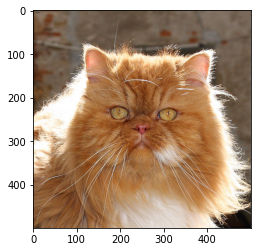

In [8]:
plt.imshow(open_image(os.path.join(DATA_DIR,files[4])))

In [9]:
class PetsDataset(Dataset):
    def __init__(self, root, transform):
        super().__init__()
        self.root = root
        self.files = [fname for fname in os.listdir(root) if fname.endswith('.jpg')] # koi txt ya aur koi format ka file na aa jae
        self.classes = list(set(parse_breed(fname) for fname in files)) # gives lisst of unique classes present in dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i] #to get file name
        fpath = os.path.join(self.root, fname) # to get full path of that file 
        img = self.transform(open_image(fpath)) #to transform 
        class_idx = self.classes.index(parse_breed(fname)) #to get index of item
        return img, class_idx

##ImageFolder will not wok here since images are not present in folders  hence ek custom class to get data file format

In [10]:
img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
dataset = PetsDataset(DATA_DIR, tt.Compose([tt.Resize(img_size), 
                                           tt.Pad(8, padding_mode='reflect'),
                                           tt.RandomCrop(img_size), 
                                           tt.ToTensor(), 
                                           tt.Normalize(*imagenet_stats)]))

In [11]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

In [12]:
val_pct = .1
val_size = int(val_pct* len(dataset))
train_size = len(dataset) - val_size
val_size,train_size
train_ds,val_ds = random_split(dataset,[train_size,val_size])
batch_size = 64
from torch.utils.data.dataloader import DataLoader
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [13]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], *imagenet_stats)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

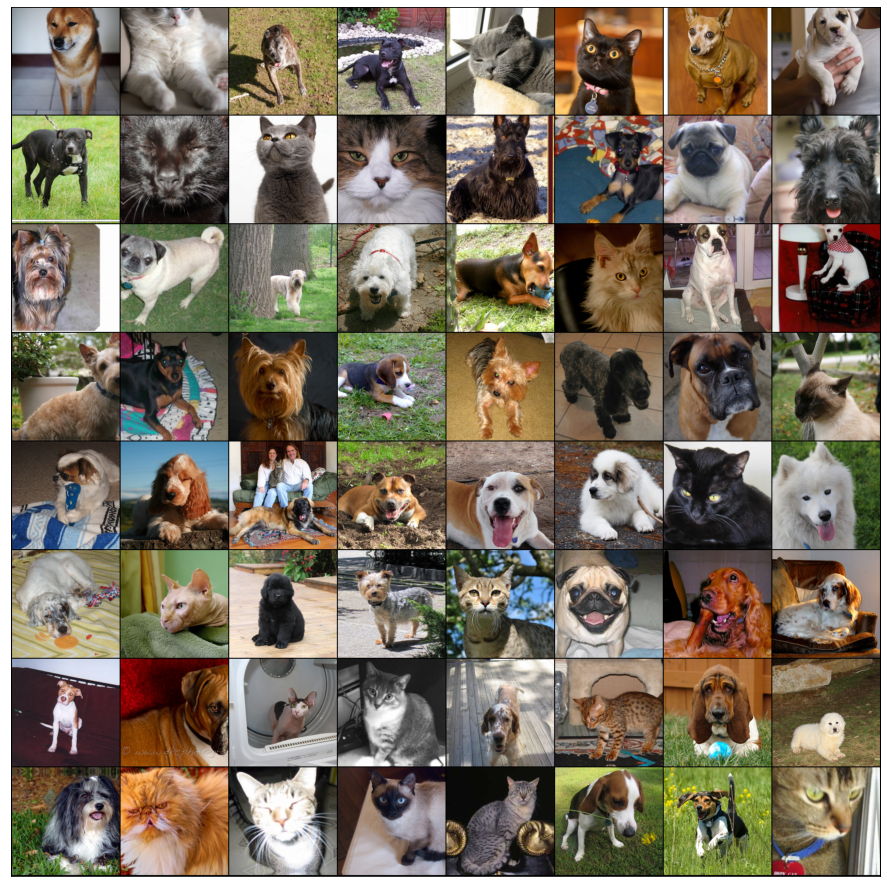

In [14]:
show_batch(train_dl)

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions yaha se forward function me pass ho jaega
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses  and calculate their mean 
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies and calculate their mean
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))


In [16]:
from torchvision import models

class PetsModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
      return self.network(xb)

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [19]:
device = get_default_device()
device

device(type='cuda')

In [20]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [21]:
model = PetsModel(len(dataset.classes))
to_device(model, device);

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [22]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 3.8526077270507812, 'val_acc': 0.013783670030534267}]

In [23]:
epochs = 3
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [24]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00994, train_loss: 2.7161, val_loss: 3.4936, val_acc: 0.0678


  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00463, train_loss: 2.3106, val_loss: 2.3888, val_acc: 0.2947


  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00000, train_loss: 1.3479, val_loss: 1.2224, val_acc: 0.6052


In [25]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00994, train_loss: 1.8788, val_loss: 3.6401, val_acc: 0.1201


  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00463, train_loss: 1.8910, val_loss: 2.2499, val_acc: 0.3858


  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00000, train_loss: 1.1438, val_loss: 1.0902, val_acc: 0.6624
